In [437]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt
import nlopt
from meep_material import lorentzfit

In [ ]:
resolution = 100
nfreq = 100

# 파장 범위 설정 (단위: μm)
# lambda_min = 0.4002
# lambda_max = 0.7005

# fmin = 1 / lambda_max
# fmax = 1 / lambda_min

# fcen = 0.5 * (fmin + fmax)

# df = fmax - fmin

fcen = 1.75
df = 3.3

In [439]:
def Material_fit(Material_data_csv=".", 
                   eps_inf=1,
                   fit_wl_min=0.38, fit_wl_max=0.72,
                   num_lorentzians=2, iteration=30
                   ):    

    # 1. 데이터 로드 및 전처리
    data = np.genfromtxt(Material_data_csv, delimiter=",")
    wl = data[:, 0] * 1e6  # 파장 (µm)
    n_data = data[:, 1] + 1j * data[:, 2]
    eps_all = np.square(n_data) - eps_inf

    # 피팅 범위로 데이터 선택
    mask = (wl >= fit_wl_min) & (wl <= fit_wl_max)
    wl_fit, eps_fit = wl[mask], eps_all[mask]
    freqs_fit = 1 / wl_fit

    # 2. Lorentzian 피팅 최적화
    ps = np.zeros((iteration, 3 * num_lorentzians))
    errors = np.zeros(iteration)
    for m in range(iteration):
        p_rand = [10 ** np.random.random() for _ in range(3 * num_lorentzians)]
        ps[m, :], errors[m] = lorentzfit(p_rand, freqs_fit, eps_fit, nlopt.LD_MMA, 1e-25, 50000)
        print(f"Iteration {m:3d}, error: {errors[m]:.6f}")
    best = np.argmin(errors)
    print(f"Optimal error: {errors[best]:.6f}")

    # 3. 최적 파라미터로 Susceptibility 생성 및 Meep 모델 구성
    suscept = []
    for i in range(num_lorentzians):
        freq_param = ps[best][3*i + 1]
        gamma = ps[best][3*i + 2]
        if freq_param == 0:
            sigma = ps[best][3*i + 0]
            suscept.append(mp.DrudeSusceptibility(frequency=1.0, gamma=gamma, sigma=sigma))
        else:
            sigma = ps[best][3*i + 0] / freq_param**2
            suscept.append(mp.LorentzianSusceptibility(frequency=freq_param, gamma=gamma, sigma=sigma))

    return eps_inf, suscept

sio2_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/SiO2/CSV/SiO2_palik_data.csv"
al_data_path   = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/Al_Palik/CSV/Al_palik_data.csv"
andp_data_path = "/home/min/EIDL/Tool/Meep/LGD/Material CSV/Al_Palik/Data/CSV file/aNDP/CSV/aNPD_PFA_data.csv"

eps_inf_sio2, suscept_sio2 = Material_fit(Material_data_csv=sio2_data_path)
eps_inf_al, suscept_al = Material_fit(Material_data_csv=al_data_path)
eps_inf_andp, suscept_andp = Material_fit(Material_data_csv=andp_data_path)

Iteration   0, error: 0.001883
Iteration   1, error: 0.000010
Iteration   2, error: 0.000005
Iteration   3, error: 0.000014
Iteration   4, error: 0.000022
Iteration   5, error: 0.000018
Iteration   6, error: 0.000005
Iteration   7, error: 0.000031
Iteration   8, error: 0.000003
Iteration   9, error: 0.000008
Iteration  10, error: 0.000012
Iteration  11, error: 0.000008
Iteration  12, error: 0.000018
Iteration  13, error: 0.000375
Iteration  14, error: 0.000011
Iteration  15, error: 0.000011
Iteration  16, error: 0.000009
Iteration  17, error: 0.000012
Iteration  18, error: 0.000012
Iteration  19, error: 0.000004
Iteration  20, error: 0.000036
Iteration  21, error: 0.000017
Iteration  22, error: 0.000012
Iteration  23, error: 0.000032
Iteration  24, error: 0.000018
Iteration  25, error: 0.000013
Iteration  26, error: 0.000007
Iteration  27, error: 0.000019
Iteration  28, error: 0.000011
Iteration  29, error: 0.000007
Optimal error: 0.000003
Iteration   0, error: 71292.592314
Iteration  

In [440]:
Glass = mp.Medium(epsilon=eps_inf_sio2, E_susceptibilities = suscept_sio2) # SiO2 
aNDP = mp.Medium(epsilon=eps_inf_andp, E_susceptibilities = suscept_andp) # aNDP 
Cathode = mp.Medium(epsilon=eps_inf_al, E_susceptibilities = suscept_al) # Al

In [441]:
### ----- Refractive index ----- ###
CoverLayer = mp.Medium(index=1.9) # SiN 
ITO_m = mp.Medium(index=1.8) 
Alq3 = mp.Medium(index=1.68) 
Air = mp.Medium(index=1.0) # 공기

In [442]:
Glass_layer = 1.37
Cover_layer = 0.07
ITO_layer = 0.15
aNDP_layer = 0.05
Alq3_layer = 0.06
Cathode_layer = 0.3

print(Glass_layer+Cover_layer+Cathode_layer+aNDP_layer+ITO_layer+Alq3_layer)

2.0


In [443]:
pml_layer = 0.3

boundary_layers = [
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.Low),  # 좌측 PML
    mp.PML(thickness=pml_layer, direction=mp.X, side=mp.High), # 우측 PML
    mp.PML(thickness=pml_layer, direction=mp.Y, side=mp.High), # 상단 PML
    
]

In [444]:
Cathode_center = mp.Vector3(0, -0.85, 0)
Alq3_center = mp.Vector3(0, -0.67, 0)
aNDP_center = mp.Vector3(0, -0.615, 0)
ITO_center = mp.Vector3(0, -0.515, 0)
Cover_center = mp.Vector3(0, -0.405, 0)
Glass_center = mp.Vector3(0, 0.315, 0)

In [445]:
geometry = [
    # Cathode (하단)
    mp.Block(
        center=Cathode_center,
        size=mp.Vector3(30, Cathode_layer, 0),
        material=Cathode
    ),
    # Alq3
    mp.Block(
        center=Alq3_center,
        size=mp.Vector3(30, Alq3_layer, 0),
        material=Alq3
    ),
    # aNDP
    mp.Block(
        center=aNDP_center,
        size=mp.Vector3(30, aNDP_layer, 0),
        material=aNDP
    ),
    # ITO
    mp.Block(
        center=ITO_center,
        size=mp.Vector3(30, ITO_layer, 0),
        material=ITO_m
    ),
    # Cover layer
    mp.Block(
        center=Cover_center,
        size=mp.Vector3(30, Cover_layer, 0),
        material=CoverLayer
    ),
    # Glass (상단; (0,0,0)은 이 Glass 내부에 위치함)
    mp.Block(
        center=Glass_center,
        size=mp.Vector3(30, Glass_layer, 0),
        material=Glass
    )
]

In [446]:
cell_size = mp.Vector3(30, 2, 0)

In [447]:
source_center = mp.Vector3(0,-0.67,0)

sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ex,
    center=source_center,
    size=mp.Vector3(0,0,0)
)]

In [448]:
# === 시뮬레이션 설정 === #
sim = mp.Simulation(
    cell_size=cell_size,
    boundary_layers=boundary_layers,
    geometry=geometry,
    sources=sources,
    resolution=resolution,
)

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


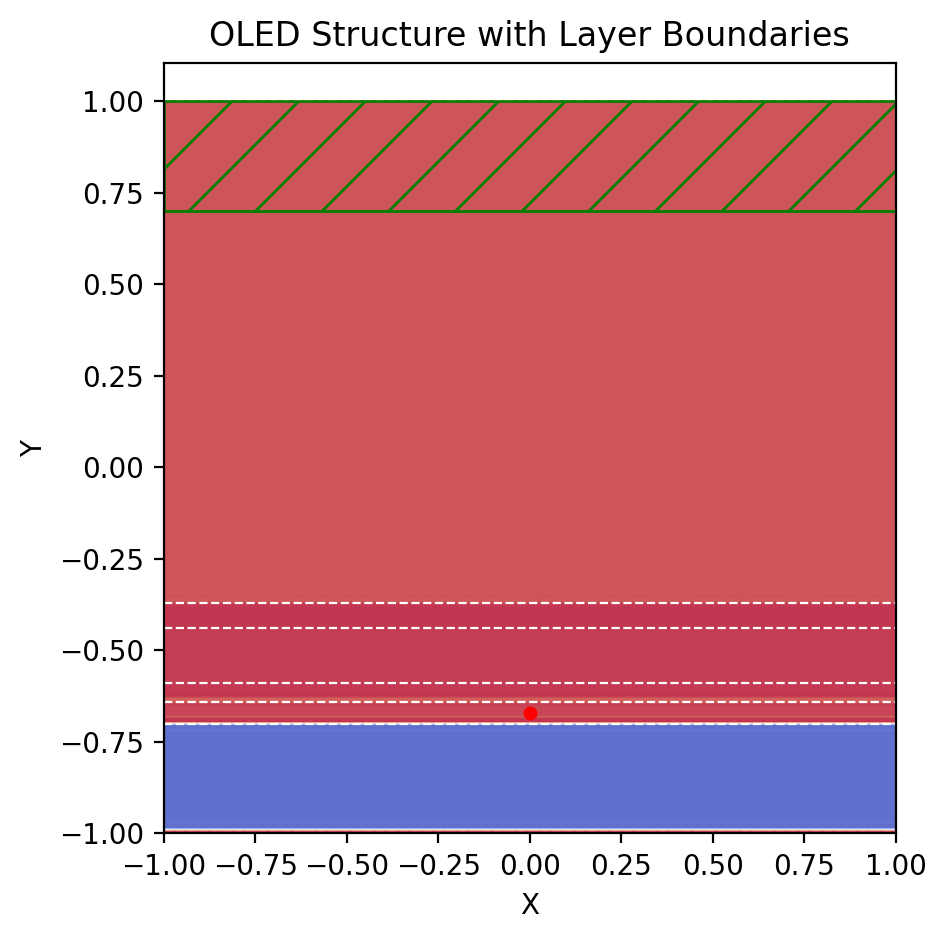

In [449]:
fig = plt.figure(dpi=200)
ax = plt.gca()
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,0,0), size=mp.Vector3(2, 2, 0)),
    eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)

layer_boundaries = [
    -1.00,  # bottom of Cathode
    -0.70,  # Cathode-Alq3
    -0.64,  # Alq3-aNDP
    -0.59,  # aNDP-ITO
    -0.44,  # ITO-Cover
    -0.37,  # Cover-Glass
    1.005   # top of Glass
]

for y in layer_boundaries:
     ax.axhline(y=y, color='white', linestyle='--', linewidth=0.8)

# === 옵션 ===
plt.title("OLED Structure with Layer Boundaries")
plt.tight_layout()
plt.show()

가우시안에 대한 필드 분포 뽑기

In [450]:
offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, -0.67,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

# 박스 4면
x1 = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux x1
    mp.FluxRegion(
        center=source_center - mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
)

x2 = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux x2
    mp.FluxRegion(
        center=source_center + mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y
    ),
)

y1 = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux y1
    mp.FluxRegion(
        center=source_center - mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
)

y2 = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux y2
    mp.FluxRegion(
        center=source_center + mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y
    ),
)

In [451]:
fcen_monitor

1.9642857142857144

     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)


          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, center = (0,0.315,0)
          size (30,1.37,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)


/home/min/miniconda3/envs/mp/lib/python3.8/site-packages/meep/visualization.py:284: UserWarning: The specified user volume is larger than the simulation domain and has been truncated.
  warnings.warn(


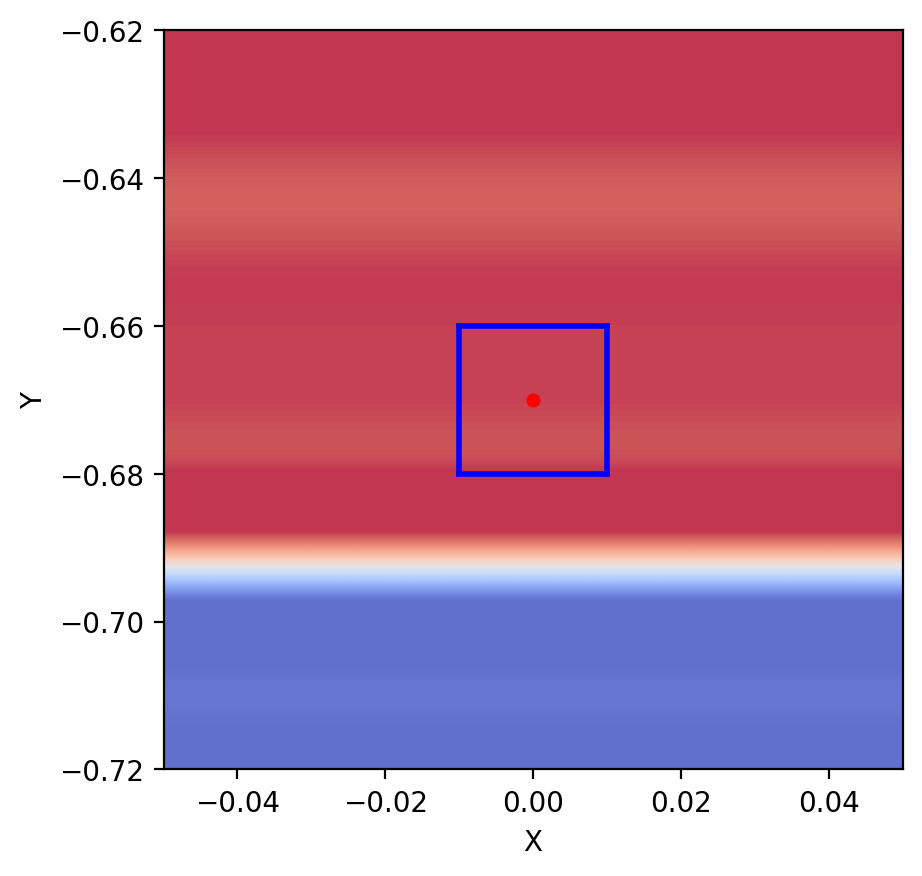

In [452]:
# center와 size를 사용해 Volume 객체 생성
vol = mp.Volume(center=mp.Vector3(0, -0.67, 0), size=mp.Vector3(2, 2, 0))
fig = plt.figure(dpi=200)
ax = plt.gca()

# 그 volume을 사용해서 2D 시각화
sim.plot2D(
    output_plane=mp.Volume(center=mp.Vector3(0,-0.67,0), size=mp.Vector3(0.1, 0.1, 0)),
    eps_parameters={'cmap': 'coolwarm', 'alpha': 0.8},   # 투명도와 컬러맵
    ax=ax
)
plt.show()

In [453]:
sim.run(until=50)

-----------
Initializing structure...
time for choose_chunkdivision = 0.000524044 s
Working in 2D dimensions.
Computational cell is 30 x 2 x 0 with resolution 100
     block, center = (0,-0.85,0)
          size (30,0.3,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.67,0)
          size (30,0.06,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (2.8224,2.8224,2.8224)
     block, center = (0,-0.615,0)
          size (30,0.05,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (1,1,1)
     block, center = (0,-0.515,0)
          size (30,0.15,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.24,3.24,3.24)
     block, center = (0,-0.405,0)
          size (30,0.07,0)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.61,3.61,3.61)
     block, 

In [454]:
net_power = np.array(mp.get_fluxes(x1))+np.array(mp.get_fluxes(x2))+np.array(mp.get_fluxes(y1))+np.array(mp.get_fluxes(y2))
# net_power = np.square(net_power)

In [455]:
frequencies = mp.get_flux_freqs(x1)

wavelengths = [1/f for f in frequencies]

print("λ (μm)\t\tdipolepower_box (W)")
for i in range(nfreq):
    print(f"{frequencies[i]:.4f}\t\t{net_power[i]:.6e}")

λ (μm)		dipolepower_box (W)
1.4286		6.474150e-03
1.4394		6.779177e-03
1.4502		7.089754e-03
1.4610		7.408186e-03
1.4719		7.732381e-03
1.4827		8.064217e-03
1.4935		8.402179e-03
1.5043		8.747504e-03
1.5152		9.099435e-03
1.5260		9.458412e-03
1.5368		9.824554e-03
1.5476		1.019743e-02
1.5584		1.057806e-02
1.5693		1.096516e-02
1.5801		1.136061e-02
1.5909		1.176236e-02
1.6017		1.217298e-02
1.6126		1.258989e-02
1.6234		1.301615e-02
1.6342		1.344884e-02
1.6450		1.389124e-02
1.6558		1.434045e-02
1.6667		1.479961e-02
1.6775		1.526615e-02
1.6883		1.574280e-02
1.6991		1.622755e-02
1.7100		1.672249e-02
1.7208		1.722641e-02
1.7316		1.774050e-02
1.7424		1.826451e-02
1.7532		1.879862e-02
1.7641		1.934357e-02
1.7749		1.989848e-02
1.7857		2.046498e-02
1.7965		2.104120e-02
1.8074		2.162945e-02
1.8182		2.222698e-02
1.8290		2.283647e-02
1.8398		2.345447e-02
1.8506		2.408364e-02
1.8615		2.471997e-02
1.8723		2.536565e-02
1.8831		2.601625e-02
1.8939		2.667301e-02
1.9048		2.733128e-02
1.9156		2.799089e-02
1.9264

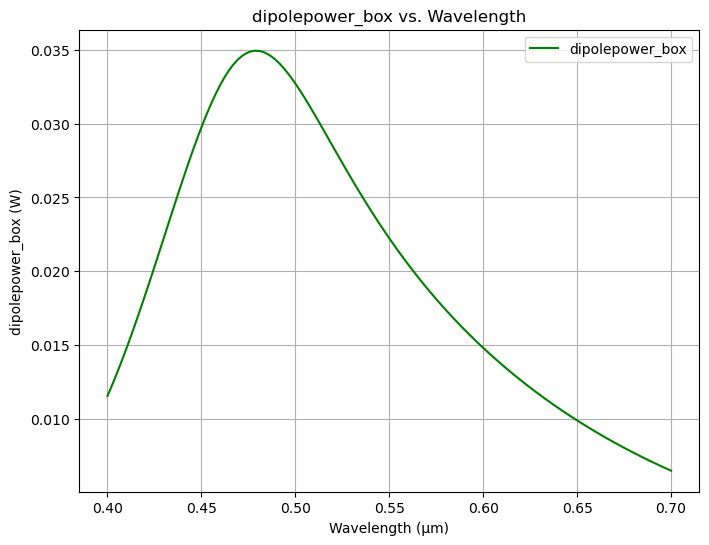

In [456]:
plt.figure(figsize=(8,6))
plt.plot(wavelengths, net_power, '-', label='dipolepower_box', color = 'green')
plt.xlabel('Wavelength (μm)')
plt.ylabel('dipolepower_box (W)')
plt.title('dipolepower_box vs. Wavelength')
# plt.ylim(-4, 14)  # y축 최소값: -4, 최대값: 14
# plt.xlim([0.4, 0.7])
plt.legend()
plt.grid(True)
plt.show()

-----------
Initializing structure...
time for choose_chunkdivision = 0.000166178 s
Working in 2D dimensions.
Computational cell is 1 x 1 x 0 with resolution 100
time for set_epsilon = 0.00589895 s
-----------
run 0 finished at t = 50.0 (10000 timesteps)
λ (μm)		net dipole power (W)
0.7000		7.695550e-04
0.6947		8.072414e-04
0.6896		8.453241e-04
0.6844		8.848508e-04
0.6794		9.247973e-04
0.6745		9.659907e-04
0.6696		1.007663e-03
0.6647		1.050321e-03
0.6600		1.093540e-03
0.6553		1.137437e-03
0.6507		1.181981e-03
0.6462		1.226866e-03
0.6417		1.272472e-03
0.6372		1.318076e-03
0.6329		1.364438e-03
0.6286		1.410472e-03
0.6243		1.457248e-03
0.6201		1.503405e-03
0.6160		1.550219e-03
0.6119		1.596177e-03
0.6079		1.642630e-03
0.6039		1.688051e-03
0.6000		1.733724e-03
0.5961		1.778255e-03
0.5923		1.822723e-03
0.5885		1.865998e-03
0.5848		1.908836e-03
0.5811		1.950480e-03
0.5775		1.991272e-03
0.5739		2.030902e-03
0.5704		2.069251e-03
0.5669		2.106482e-03
0.5634		2.142016e-03
0.5600		2.176466e-03
0.

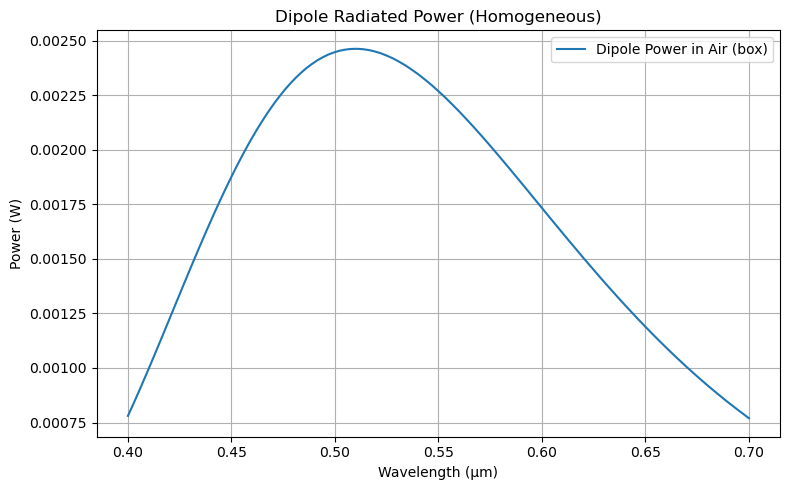

In [472]:
sim.init_sim()

cell_size = (1,1,0)

boundary_layer = [
    mp.PML(0.3, mp.X),
    mp.PML(0.3, mp.Y)
                  ]

resolution = 100
nfreq = 100

lambda_min = 0.4
lambda_max = 0.7

fmin = 1 / lambda_max
fmax = 1 / lambda_min

fcen_monitor = 0.5*(fmin+fmax)
df_monitor = fmax-fmin

fcen = 1.75
df=3.3

source_center = mp.Vector3(0,0,0)
sources = [mp.Source(
    src=mp.GaussianSource(frequency=fcen, fwidth=df),
    component=mp.Ex,
    center=source_center,
    size=mp.Vector3(0,0)
)]

sim = mp.Simulation(
    cell_size=cell_size,
    default_material=mp.Medium(index=1),
    boundary_layers=boundary_layer,
    sources=sources,
    resolution=resolution
)


offset = 0.01
flux_size = 0.02

# Dipole 위치
source_center = mp.Vector3(0, 0,0)

focus_lambda_min = 0.4
focus_lambda_max = 0.7

focus_f_min = 1/focus_lambda_max
focus_f_max = 1/focus_lambda_min

fcen_monitor = 0.5 * (focus_f_min + focus_f_max)
df_monitor = focus_f_max - focus_f_min

# 박스 4면
x1_air = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux x1
    mp.FluxRegion(
        center=source_center - mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
)

x2_air = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux x2
    mp.FluxRegion(
        center=source_center + mp.Vector3(offset, 0,0),
        size=mp.Vector3(0,flux_size, 0),
        # direction=mp.Y
    ),
)

y1_air = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux y1
    mp.FluxRegion(
        center=source_center - mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y,
        weight=-1
    ),
)

y2_air = sim.add_flux(
    fcen_monitor, df_monitor, nfreq, 
    # flux y2
    mp.FluxRegion(
        center=source_center + mp.Vector3(0, offset, 0),
        size=mp.Vector3(flux_size, 0),
        # direction=mp.Y
    ),
)

# === 시뮬레이션 실행 ===
sim.run(until=50)
# sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ey, mp.Vector3(), 1e-8))

# === 측정된 flux 데이터 얻기 ===
flux_freqs = mp.get_flux_freqs(x1_air)   # 측정된 주파수 배열 (1/μm)
x1_air = mp.get_fluxes(x1_air)        # 측정된 각 주파수의 dipole 방사 power (W)
x2_air_val = mp.get_fluxes(x2_air)        # 측정된 각 주파수의 dipole 방사 power (W)
y1_air_val = mp.get_fluxes(y1_air)        # 측정된 각 주파수의 dipole 방사 power (W)
y2_air_val = mp.get_fluxes(y2_air)        # 측정된 각 주파수의 dipole 방사 power (W)

# === 파장으로 변환 (μm)
wavelengths = 1 / np.array(flux_freqs)

# === 결과 출력 예시
print("λ (μm)\t\tnet dipole power (W)")
for i in range(nfreq):
    print(f"{wavelengths[i]:.4f}\t\t{x1_air[i]:.6e}")

# === 시각화 (옵션)
plt.figure(figsize=(8,5))
plt.plot(wavelengths, x1_air, label="Dipole Power in Air (box)", )
plt.xlabel("Wavelength (μm)")
plt.ylabel("Power (W)")
plt.title("Dipole Radiated Power (Homogeneous)")
# plt.ylim([-3, 14])
# plt.xlim([0.1,1])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


λ (μm)		dipolepower_box (W)
1.4286		6.474150e-03
1.4394		6.779177e-03
1.4502		7.089754e-03
1.4610		7.408186e-03
1.4719		7.732381e-03
1.4827		8.064217e-03
1.4935		8.402179e-03
1.5043		8.747504e-03
1.5152		9.099435e-03
1.5260		9.458412e-03
1.5368		9.824554e-03
1.5476		1.019743e-02
1.5584		1.057806e-02
1.5693		1.096516e-02
1.5801		1.136061e-02
1.5909		1.176236e-02
1.6017		1.217298e-02
1.6126		1.258989e-02
1.6234		1.301615e-02
1.6342		1.344884e-02
1.6450		1.389124e-02
1.6558		1.434045e-02
1.6667		1.479961e-02
1.6775		1.526615e-02
1.6883		1.574280e-02
1.6991		1.622755e-02
1.7100		1.672249e-02
1.7208		1.722641e-02
1.7316		1.774050e-02
1.7424		1.826451e-02
1.7532		1.879862e-02
1.7641		1.934357e-02
1.7749		1.989848e-02
1.7857		2.046498e-02
1.7965		2.104120e-02
1.8074		2.162945e-02
1.8182		2.222698e-02
1.8290		2.283647e-02
1.8398		2.345447e-02
1.8506		2.408364e-02
1.8615		2.471997e-02
1.8723		2.536565e-02
1.8831		2.601625e-02
1.8939		2.667301e-02
1.9048		2.733128e-02
1.9156		2.799089e-02
1.9264

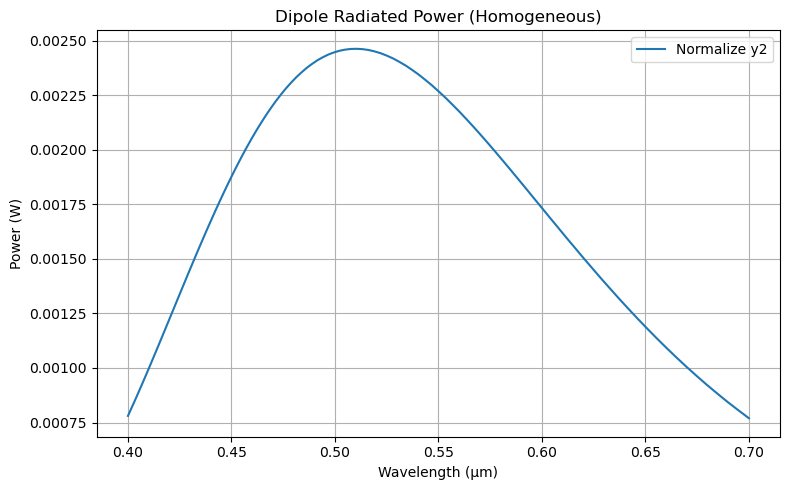

In [480]:
frequencies = mp.get_flux_freqs(x1)
x1_oled = mp.get_fluxes(x1)
x2_oled = mp.get_fluxes(x2)
y1_oled = mp.get_fluxes(y1)
y2_oled = mp.get_fluxes(y2)


# norm_x1 = np.array(y2_oled)/np.array(y2_air_val)

wavelengths = [1/f for f in frequencies]

print("λ (μm)\t\tdipolepower_box (W)")
for i in range(nfreq):
    print(f"{frequencies[i]:.4f}\t\t{net_power[i]:.6e}")

plt.figure(figsize=(8,5))
# plt.plot(wavelengths, x1_air, label="Dipole Power in Air (x1)", )
# plt.plot(wavelengths, x1_oled, label="Dipole Power in OLED (x1)", )
plt.plot(wavelengths, x2_air_val, label="Normalize y2", )

plt.xlabel("Wavelength (μm)")
plt.ylabel("Power (W)")
plt.title("Dipole Radiated Power (Homogeneous)")
# plt.ylim([-3, 14])
# plt.xlim([0.1,1])
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [118]:
import numpy as np

# CSV 파일 불러오기
data = np.genfromtxt("dipole_power.csv", delimiter=",", skip_header=1)

# 데이터 분리
wavelengths = data[:, 0]
source_power = data[:, 1]

# 슬라이싱: 0.5μm ≤ λ ≤ 1.0μm
# mask = (wavelengths >= 0) & (wavelengths <= 10)
wavelength_sliced = wavelengths
power_sliced = source_power

# 결과 출력
print("슬라이싱된 wavelength:", wavelength_sliced)
print("슬라이싱된 power:", power_sliced)

슬라이싱된 wavelength: [0.7        0.69473684 0.68955224 0.68444444 0.67941176 0.67445255
 0.66956522 0.6647482  0.66       0.65531915 0.65070423 0.64615385
 0.64166667 0.63724138 0.63287671 0.62857143 0.62432432 0.62013423
 0.616      0.61192053 0.60789474 0.60392157 0.6        0.59612903
 0.59230769 0.58853503 0.58481013 0.58113208 0.5775     0.57391304
 0.57037037 0.56687117 0.56341463 0.56       0.55662651 0.55329341
 0.55       0.54674556 0.54352941 0.54035088 0.5372093  0.53410405
 0.53103448 0.528      0.525      0.5220339  0.51910112 0.51620112
 0.51333333 0.51049724 0.50769231 0.50491803 0.50217391 0.49945946
 0.49677419 0.49411765 0.49148936 0.48888889 0.48631579 0.48376963
 0.48125    0.47875648 0.47628866 0.47384615 0.47142857 0.46903553
 0.46666667 0.46432161 0.462      0.45970149 0.45742574 0.45517241
 0.45294118 0.45073171 0.44854369 0.44637681 0.44423077 0.44210526
 0.44       0.43791469 0.43584906 0.43380282 0.4317757  0.42976744
 0.42777778 0.42580645 0.42385321 0.42191781

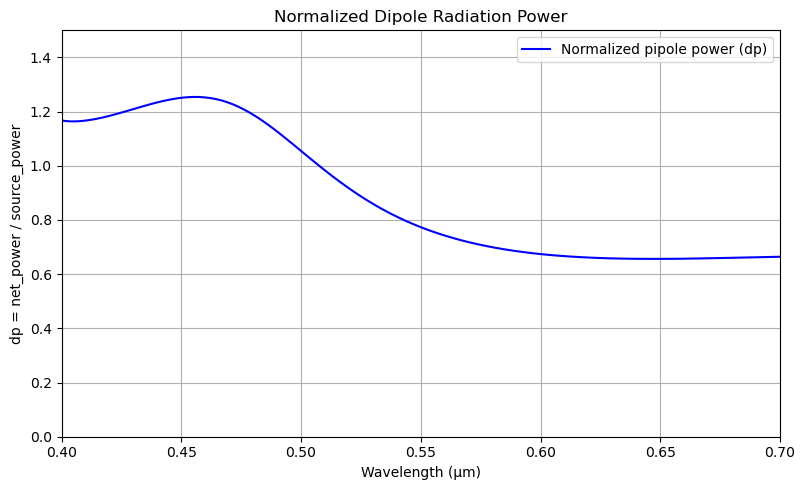

In [121]:
dp = net_power / source_power

# 5. Plot
plt.figure(figsize=(8, 5))
# plt.plot(wavelengths, source_power, '-', label='Homogeneous dipole power', )
plt.plot(wavelengths, dp,  label='Normalized pipole power (dp)', color='blue')
# plt.plot(wavelengths, net_power, '-', label='Dipolepower_box', color = 'green')

plt.xlabel("Wavelength (μm)")
plt.ylabel("dp = net_power / source_power")
plt.title("Normalized Dipole Radiation Power")
plt.grid(True)
plt.legend()
plt.tight_layout()
# plt.yscale("log")

plt.ylim([0, 1.5])
plt.xlim([0.4, 0.7])
plt.show()

sim.add_flux(...) → Fourier-transformed field 데이터를 누적 시작

sim.get_fluxes(flux_obj) → 누적된 데이터를 바탕으로 power 계산

sim.get_dft_array(...) → 실제 E, H field의 Fourier transformed 값을 배열로 받을 수 있음

→ 파장이 길어질수록 source dipole의 방사효율은 줄어들지만, 시스템은 에너지를 더 잘 전달함 → dp 증가.

In [406]:
x1_flux = mp.get_fluxes(x1)
x2_flux = mp.get_fluxes(x2)
y1_flux = mp.get_fluxes(y1)
y2_flux = mp.get_fluxes(y2)

import numpy as np

# CSV 파일 불러오기
data = np.genfromtxt("dipole_power.csv", delimiter=",", skip_header=1)

# 데이터 분리
wavelengths = data[:, 0]
source_power = data[:, 1]

# 슬라이싱: 0.5μm ≤ λ ≤ 1.0μm
# mask = (wavelengths >= 0) & (wavelengths <= 10)
wavelength_sliced = wavelengths
power_sliced = source_power

# 결과 출력
print("슬라이싱된 wavelength:", wavelength_sliced)
print("슬라이싱된 power:", power_sliced)

슬라이싱된 wavelength: [10.          7.5         6.          5.          4.28571429  3.75
  3.33333333  3.          2.72727273  2.5         2.30769231  2.14285714
  2.          1.875       1.76470588  1.66666667  1.57894737  1.5
  1.42857143  1.36363636  1.30434783  1.25        1.2         1.15384615
  1.11111111  1.07142857  1.03448276  1.          0.96774194  0.9375
  0.90909091  0.88235294  0.85714286  0.83333333  0.81081081  0.78947368
  0.76923077  0.75        0.73170732  0.71428571  0.69767442  0.68181818
  0.66666667  0.65217391  0.63829787  0.625       0.6122449   0.6
  0.58823529  0.57692308  0.56603774  0.55555556  0.54545455  0.53571429
  0.52631579  0.51724138  0.50847458  0.5         0.49180328  0.48387097
  0.47619048  0.46875     0.46153846  0.45454545  0.44776119  0.44117647
  0.43478261  0.42857143  0.42253521  0.41666667  0.4109589   0.40540541
  0.4         0.39473684  0.38961039  0.38461538  0.37974684  0.375
  0.37037037  0.36585366  0.36144578  0.35714286  0.35294118  

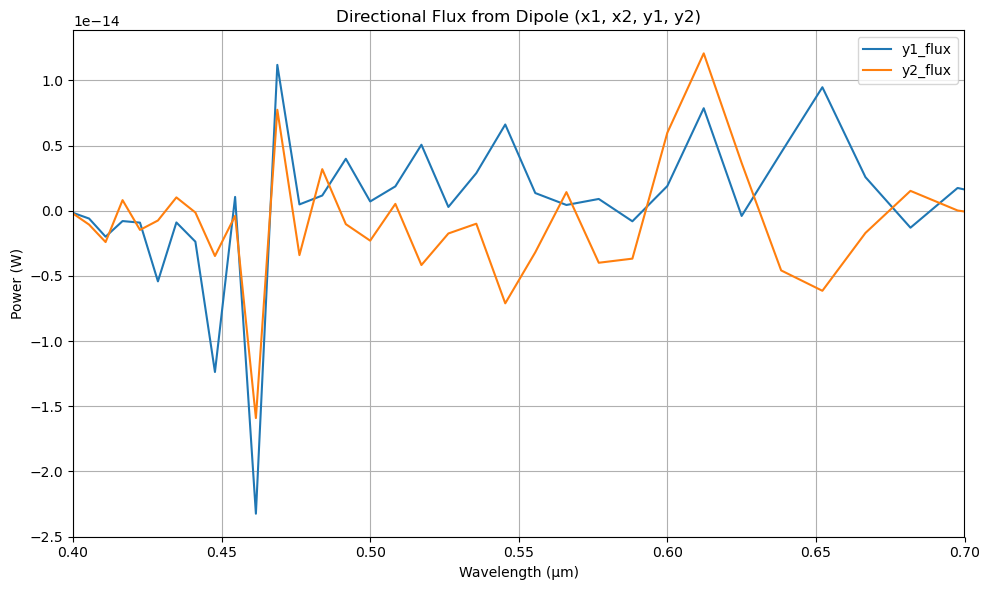

In [436]:
# x1 ~ y2: 이미 get_fluxes로 계산된 리스트라고 가정
# 각각의 이름 붙이기
labels = ['x1 (left)', 'x2 (right)', 'y1 (bottom)', 'y2 (top)']
colors = ['red', 'blue', 'green', 'orange']

flux_list = [x1_flux, x2_flux, y1_flux, y2_flux]

# 그래프 출력
plt.figure(figsize=(10, 6))
# for i in range(4):
#     plt.plot(wavelength_sliced, flux_list[i], label=labels[i], color=colors[i])
# plt.plot(wavelength_sliced, x1_flux, label = 'x1_flux')
# plt.plot(wavelength_sliced, x2_flux, label = 'x2_flux')

plt.plot(wavelength_sliced, y1_flux, label = 'y1_flux')
plt.plot(wavelength_sliced, y2_flux, label = 'y2_flux')

plt.xlabel("Wavelength (μm)")
plt.ylabel("Power (W)")
plt.title("Directional Flux from Dipole (x1, x2, y1, y2)")
plt.legend()
plt.xlim([0.4, 0.7])
plt.grid(True)
plt.tight_layout()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


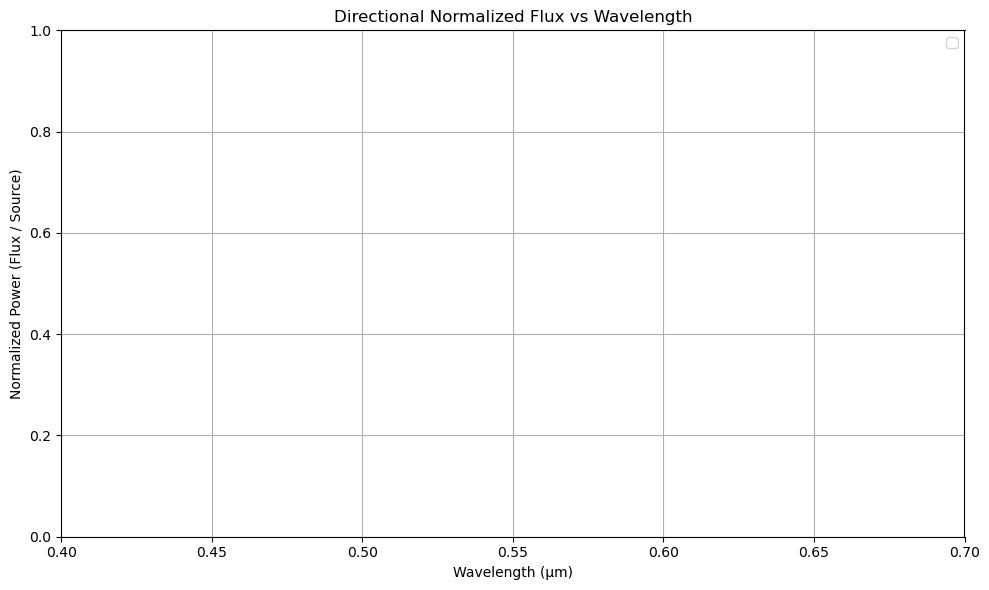

In [435]:
x1_norm = np.array(x1_flux) / power_sliced
x2_norm = np.array(x2_flux) / power_sliced
y1_norm = np.array(y1_flux) / power_sliced
y2_norm = np.array(y2_flux) / power_sliced

# --- Plotting ---
plt.figure(figsize=(10, 6))

# plt.plot(wavelength_sliced, x1_norm, label='x1 (left)', color='red')
# plt.plot(wavelength_sliced, x2_norm, label='x2 (right)', color='blue')
# plt.plot(wavelength_sliced, y1_norm, label='y1 (bottom)', color='green')
# plt.plot(wavelength_sliced, y2_norm, label='y2 (top)', color='orange')

plt.xlabel("Wavelength (μm)")
plt.ylabel("Normalized Power (Flux / Source)")
plt.title("Directional Normalized Flux vs Wavelength")
plt.grid(True)
plt.xlim([0.4, 0.7])
plt.legend()
plt.tight_layout()
plt.show()